# Instancia de librarias

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import datetime as dt
from datetime import datetime # Trabajar con fechas

# Metricas de desempeño de modelos 
import scipy.stats as stats
import statistics
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler  # Estandarización de los datos
from sklearn.model_selection import cross_val_score

# Series de tiempo
# from statsmodels.tsa.seasonal import seasonal_decompose # graficas de estacionalidad y tendencia
# from statsmodels.tsa.stattools import adfuller # prueba 
# from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
# import pmdarima as pm # autoarima
# import statsmodels.formula.api as smf

# Prophet

# !pip3 install more-itertools --user
# !pip install prophet --user
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly

# Formato de visualización por centenas
pd.options.display.float_format = '{:,.2f}'.format

# Graficas
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_theme(color_codes=True)

# Tamaño del cuadro de las gráficas por defult
plt.rcParams["figure.figsize"] = (12,6)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Setup complete")

Setup complete


In [ ]:
#TODO Skills: Aplica comentarios de prophet_month_2.ipynb

# Importación de datos

In [2]:
path = r'E:\\skillsForIndustry/project_wallmart/data/Walmart_Store_sales.csv'
wall_data = pd.read_csv(path, header=0, encoding='utf-8')

In [3]:
wall_data['Date'] = pd.to_datetime(wall_data['Date'],format="%d-%m-%Y",dayfirst=True)
wall_data.info()
wall_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11


#### Frecuencia de tiempo

In [4]:
# Semanal
stores = wall_data
stores = stores.iloc[:,[1,0,2]]
stores['Store'] = stores.Store.astype(str)
stores.columns = ['Date','Store','Weekly_Sales']

# Mensual
# Mensual con frecuencia
# stores = wall_data
# stores = stores.iloc[:,[1,0,2]]
# stores.Date = pd.PeriodIndex(stores.Date, freq='M')
# # stores = stores.groupby(['Date'])['Weekly_Sales'].aggregate([sum,min,'mean','count']).reset_index()
# stores = stores.groupby(['Date','Store'])['Weekly_Sales'].mean().reset_index()
# stores['Date'] = stores['Date'].astype(str)
# stores['Store'] = stores.Store.astype(str)
# stores['Date'] =pd.to_datetime(stores['Date'])
# stores.head()

# Mensual sin frecuencia 
# stores = wall_data
# stores = stores.iloc[:,[1,0,2]]
# stores['year'] = pd.DatetimeIndex(stores['Date']).year
# stores['month'] = pd.DatetimeIndex(stores['Date']).month
# stores= stores.groupby(['year','month','Store'])[['Weekly_Sales']].mean().reset_index()
# stores['year_str']=stores.year.apply(str)
# stores['month_str']=stores.month.apply(str)
# stores['Store'] = stores.Store.astype(str)
# stores['year_month'] = stores[['year_str','month_str']].apply('-'.join,axis=1)
# stores['Date']=pd.to_datetime(stores['year_month'],format="%Y-%m",yearfirst=True)
# stores = stores.iloc[:,[7,2,3]]
# stores.head()

In [5]:
num_store = stores['Store'].unique()
num_store

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45'],
      dtype=object)

In [6]:
sem = {}
for store in num_store:
    df = stores[stores['Store']==store].copy()
    df.drop('Store',axis=1, inplace=True)
    sem[store] = df
    df.columns = ['ds','y']
    df.rename_axis(index=None,columns=None)
   
# Elegir una tienda    
# sem['20']

#### Performance

In [7]:
def performance(a,b):
    print('Mean Absolute Error: ',metrics.mean_absolute_error(a,b))
    print('Mean Square Error: ',metrics.mean_squared_error(a,b))
    print('Root Mean Square Error: ',np.sqrt(metrics.mean_squared_error(a,b)))
    print('Mean Absolute Percentage Error: ', metrics.mean_absolute_percentage_error(a,b))
    
    plt.figure(figsize=(10,8),dpi=60)
    sns.regplot(b,a);

#### Conjunto de entrenamiento y test

In [8]:
def tra_tes(st,period):
    train = st.sort_values('ds')[:len(st)-period]  # primero datos
    test = st.sort_values('ds')[len(st)-period:]   # últimos datos 
    return train,test

# tra_tes(dataframe,period='num_Semanas')

## Semanas y tiendas

In [9]:
s_20 =  sem['20']
s_14 =  sem['14'] # No son datos estacionarios
s_13 =  sem['13']
s_10 =  sem['10']
s_26 =  sem['26']
s_27 =  sem['27']
s_23 =  sem['23']
s_24 =  sem['24']
s_37 = sem['37']
s_39 = sem['39']
s_30 = sem['30']
s_44 = sem['44']
s_31 = sem['31']
s_19 = sem['19']
s_5 = sem['5']

## Prophet

## Elegit tienda y periodicidad

In [25]:
# pr = 12,24,32,40,48,52
pr = 48
s_t = s_20

In [26]:
vnames = [name for name in globals() if globals()[name] is s_t]
# print(vnames[0])

#### Con Entrenamiento y Test

In [27]:
# tra_tes(dataframe,period='num_Semanas')
train, test = tra_tes(s_t,pr)

Tienda: s_20


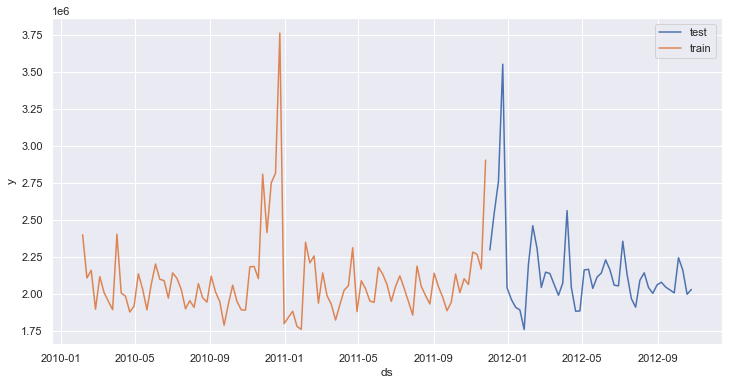

In [28]:
print('Tienda:',vnames[0])
sns.lineplot(data=test, x = 'ds',y ='y', label='test');
sns.lineplot(data=train, x = 'ds',y ='y', label='train');

Tienda: s_20


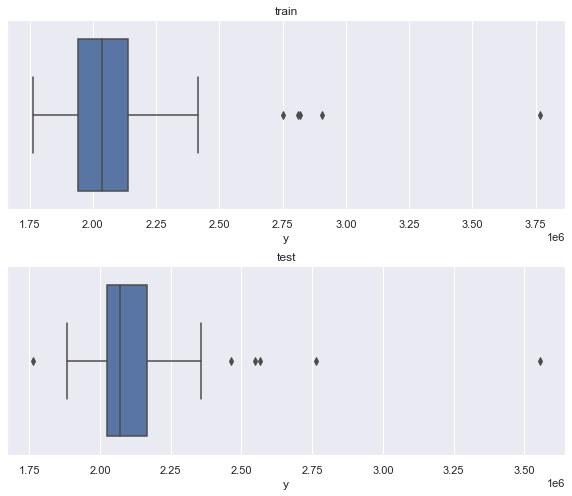

In [29]:
print('Tienda:',vnames[0])
fig, axs = plt.subplots(2,figsize=(10,8))
sns.boxplot(train['y'], ax=axs[0]).set_title("train")
sns.boxplot(test['y'], ax=axs[1]).set_title('test')
fig.subplots_adjust(hspace=0.3)


#### Intanciar al modelo y entrenarlo

In [30]:
iw=0.95
cps = 0.0001
ys= 20
m = Prophet(interval_width=iw, changepoint_prior_scale=cps, yearly_seasonality=ys)

# Pasandole test o train
m.fit(train)
# m.fit(test)

07:37:22 - cmdstanpy - INFO - Chain [1] start processing
07:37:23 - cmdstanpy - INFO - Chain [1] done processing


#### Construir futuro

In [31]:
# El pr(perido) puede ser modififcado para calcular más semanas adelante,
# en caso contrario tomará el valor que se le pasa al definir train y test
# pr = 60
fr = 'W-FRI'
future = m.make_future_dataframe(periods=pr, freq=fr)

# Hacer predicciones
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
138,2012-09-28,"2,165,419.38","1,781,723.40","2,149,765.96","2,165,419.28","2,165,419.48","-206,109.54","-206,109.54","-206,109.54","-206,109.54","-206,109.54","-206,109.54",0.00,0.00,0.00,"1,959,309.84"
139,2012-10-05,"2,165,940.27","1,915,432.30","2,290,498.89","2,165,940.18","2,165,940.37","-71,199.04","-71,199.04","-71,199.04","-71,199.04","-71,199.04","-71,199.04",0.00,0.00,0.00,"2,094,741.23"
140,2012-10-12,"2,166,461.17","1,915,867.73","2,285,344.78","2,166,461.07","2,166,461.27","-61,665.28","-61,665.28","-61,665.28","-61,665.28","-61,665.28","-61,665.28",0.00,0.00,0.00,"2,104,795.89"
141,2012-10-19,"2,166,982.06","1,831,887.81","2,193,084.13","2,166,981.96","2,166,982.16","-152,554.89","-152,554.89","-152,554.89","-152,554.89","-152,554.89","-152,554.89",0.00,0.00,0.00,"2,014,427.17"
142,2012-10-26,"2,167,502.95","1,830,731.31","2,214,819.90","2,167,502.85","2,167,503.06","-142,557.22","-142,557.22","-142,557.22","-142,557.22","-142,557.22","-142,557.22",0.00,0.00,0.00,"2,024,945.73"


Tienda: s_20


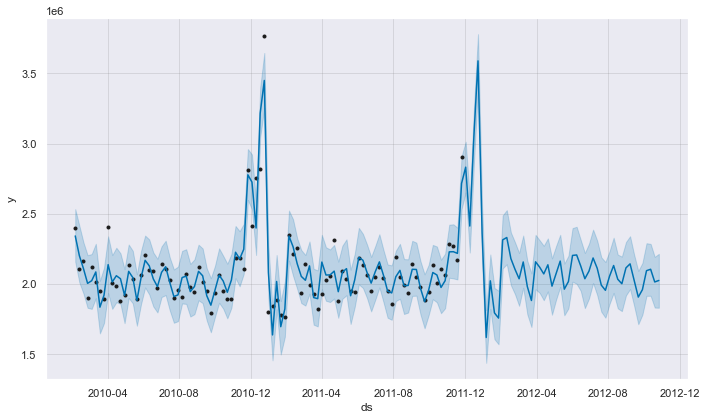

In [32]:
print('Tienda:',vnames[0])
plot = m.plot(forecast)

Tienda: s_20


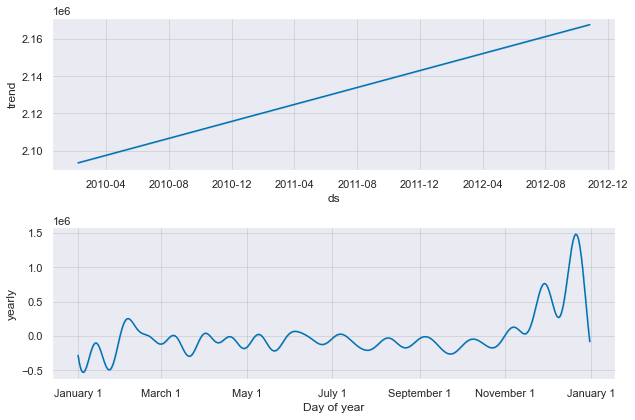

In [33]:
print('Tienda:',vnames[0])
plot2 = m.plot_components(forecast)

In [34]:
pp = pd.DataFrame({'Date':forecast[-pr:]['ds'],'Pred':forecast[-pr:]['yhat']})
pp.head()

,Date,Pred
95,2011-12-02,"2,832,020.24"
96,2011-12-09,"2,412,623.59"
97,2011-12-16,"3,052,030.64"
98,2011-12-23,"3,589,251.92"
99,2011-12-30,"2,360,440.57"


In [35]:
train.columns = ['Date','Pred']
test.columns = ['Date','Pred']

x_train = train.Date
y_train  = train.Pred
x_test = test.Date
y_test  = test.Pred
x_pp = pp.Date
y_pp = pp.Pred


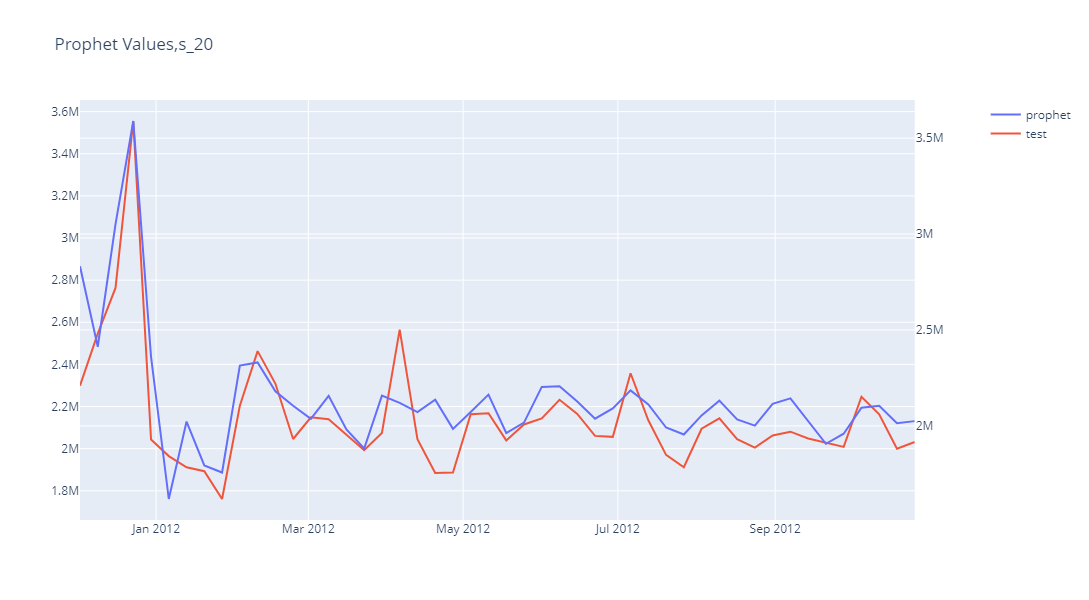

In [36]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x = x_pp ,y = y_pp, name="prophet"),
    secondary_y=True
)

fig.add_trace(
    go.Scatter(x = x_test,y = y_test, name="test"),
    secondary_y=False
)


fig.update_layout(
    title_text=f"Prophet Values,{vnames[0]}",
    width = 1000, height = 600
)

fig.show()

In [37]:
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig.add_trace(
#     go.Scatter(x = x_pp ,y = y_pp, name="prophet"),
#     secondary_y=True
# )

# fig.add_trace(
#     go.Scatter(x = x_train,y = y_train, name="train"),
#     secondary_y=False
# )

# fig.update_layout(
#     title_text="Prophet Values",
#     width = 1000, height = 600
# )

# fig.show()

In [38]:
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig.add_trace(
#     go.Scatter(x = x_test,y = y_test, name="test"),
#     secondary_y=False
# )

# fig.add_trace(
#     go.Scatter(x = x_train,y = y_train, name="train"),
#     secondary_y=True
# )

# fig.update_layout(
#     title_text="Prophet Values",
#     width = 1000, height = 600
# )

# fig.show()


Tienda: s_20
Accuracy test(R2):  69.7259437161456
Mean Absolute Error:  100960.41127847998
Mean Square Error:  23063641957.041317
Root Mean Square Error:  151867.18525422574
Mean Absolute Percentage Error:  0.04623090300461966


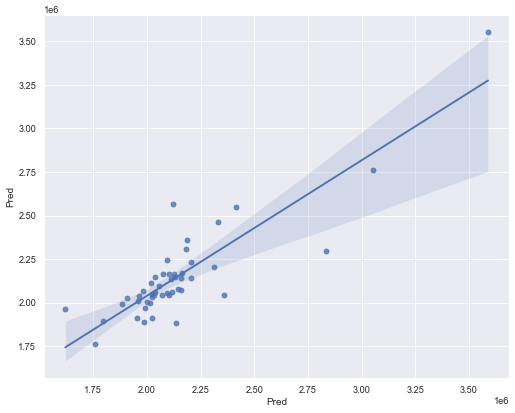

In [39]:
print('Tienda:',vnames[0])
print('Accuracy test(R2): ', metrics.r2_score(test.Pred,pp.Pred)*100)
performance(test.Pred,pp.Pred)